# Setup the optimization problem

## Ensure path (weight vector -> loss on MNIST) is differentiable

# Train two networks

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


import lovely_tensors as lt
lt.monkey_patch()

from tqdm.auto import tqdm

In [3]:
device = 'cuda:0'
batch_size = 128

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Load and normalize MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Train the network
num_epochs = 3

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [37]:
import torch
import torch.nn.functional as F

def kaiming_init(tensor):
    fan_in = tensor.shape[1]
    gain = torch.nn.init.calculate_gain('relu')
    std = gain / torch.sqrt(torch.tensor(fan_in, dtype=torch.float32))
    return tensor.normal_(0, std.item())

class RawSimpleCNN5:
    def __init__(self):
        # Initialize weights and biases using Kaiming initialization
        self.W1 = kaiming_init(torch.empty(32, 1, 3, 3))
        self.b1 = torch.zeros(32)
        self.W2 = kaiming_init(torch.empty(64, 32, 3, 3))
        self.b2 = torch.zeros(64)
        self.W3 = kaiming_init(torch.empty(128, 64, 3, 3))
        self.b3 = torch.zeros(128)
        self.W4 = kaiming_init(torch.empty(256, 128, 3, 3))
        self.b4 = torch.zeros(256)
        self.W_fc1 = kaiming_init(torch.empty(10, 256))
        self.b_fc1 = torch.zeros(10)

        self.parameters = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4, self.W_fc1, self.b_fc1]
        for p in self.parameters:
            p.requires_grad=True
        
        
    def to(self, *args, **kwargs):
        for i, p in enumerate(self.parameters):
            self.parameters[i] = p.to(*args, **kwargs)
        return self

    def raw_forward(self, x, params=None):
        if params is None:
            params = self.parameters

        W1, b1, W2, b2, W3, b3, W4, b4, W_fc1, b_fc1 = params

        x = F.conv2d(x, W1, b1, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = F.conv2d(x, W2, b2, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = F.conv2d(x, W3, b3, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = F.conv2d(x, W4, b4, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 256)

        x = F.linear(x, W_fc1, b_fc1)

        return x

def parameters_to_simple_cnn(params):
    model = SimpleCNN()
    model.conv1.weight.data.copy_(params[0])
    model.conv1.bias.data.copy_(params[1])
    model.conv2.weight.data.copy_(params[2])
    model.conv2.bias.data.copy_(params[3])
    model.conv3.weight.data.copy_(params[4])
    model.conv3.bias.data.copy_(params[5])
    model.conv4.weight.data.copy_(params[6])
    model.conv4.bias.data.copy_(params[7])
    model.fc1.weight.data.copy_(params[8].t())
    model.fc1.bias.data.copy_(params[9])

    return model

class RawSimpleCNN3:
    def __init__(self):
        # Initialize weights and biases using Kaiming initialization
        self.W1 = kaiming_init(torch.empty(8, 1, 3, 3))
        self.b1 = torch.zeros(8)
        self.W2 = kaiming_init(torch.empty(8, 8, 3, 3))
        self.b2 = torch.zeros(8)
        # self.W3 = kaiming_init(torch.empty(128, 64, 3, 3))
        # self.b3 = torch.zeros(128)
        # self.W4 = kaiming_init(torch.empty(256, 128, 3, 3))
        # self.b4 = torch.zeros(256)
        self.W_fc1 = kaiming_init(torch.empty(10, 392))
        self.b_fc1 = torch.zeros(10)

        self.parameters = [self.W1, self.b1, self.W2, self.b2, self.W_fc1, self.b_fc1]
        for p in self.parameters:
            p.requires_grad=True
        
        
    def to(self, *args, **kwargs):
        for i, p in enumerate(self.parameters):
            self.parameters[i] = p.to(*args, **kwargs)
        return self

    def raw_forward(self, x, params=None):
        if params is None:
            params = self.parameters

        bs = x.shape[0]
        W1, b1, W2, b2, W_fc1, b_fc1 = params

        x = F.conv2d(x, W1, b1, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = F.conv2d(x, W2, b2, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = x.view(bs, -1)

        x = F.linear(x, W_fc1, b_fc1)

        return x

def parameters_to_simple_cnn(params):
    model = RawSimpleCNN3()
    model.conv1.weight.data.copy_(params[0])
    model.conv1.bias.data.copy_(params[1])
    model.conv2.weight.data.copy_(params[2])
    model.conv2.bias.data.copy_(params[3])
    model.fc1.weight.data.copy_(params[4].t())
    model.fc1.bias.data.copy_(params[5])

    return model

# Test the raw_forward function
RawSimpleCNN = RawSimpleCNN3
raw_net = RawSimpleCNN().to(device)

In [38]:
import os
import random
import numpy as np
import torch

def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [39]:
def net2params(raw_net):
    params_shapes = []
    params = []

    for p in raw_net.parameters:
        params_shapes.append( p.shape )
        params.append(p.flatten())

    param_vec = torch.cat(params)
    return param_vec, params_shapes

In [40]:
def product(li):
    p = 1
    for e in li:
        p *= e
    return p

def reconstruct_params(param_vec, params_shapes):
    offset = 0
    reconstructed_params = []

    for shape in params_shapes:
        n = product(shape)
        p = param_vec[offset:offset+n]
        p = p.reshape(shape)

        reconstructed_params.append(p)

        offset += n
        
    return reconstructed_params

In [41]:
def param_vec2net(param_vec, params_shapes):
    params = reconstruct_params
    raw_net = RawSimpleCNN()
    
    reconstructed_params = reconstruct_params(param_vec, params_shapes)
    raw_net.parameters = reconstructed_params
    return raw_net

In [42]:
def train(num_epochs=2, seed=42):
    seed=42
    seed_all(seed)
    print(f'Set seed={seed}')

    param_vec, params_shapes = net2params(RawSimpleCNN())
    param_vec = param_vec.detach().to(device)
    param_vec.requires_grad = True

    optimizer = optim.AdamW([param_vec], lr=3e-4)
    epoch_losses = []
    pbar = tqdm(range(num_epochs))

    for epoch in pbar:
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            raw_net = param_vec2net(param_vec, params_shapes)
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = raw_net.raw_forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print(loss.item())

            running_loss += loss.item()

        avg_loss = running_loss / ((i + 1))
        epoch_losses.append(avg_loss)
        pbar.set_description(f"Epoch {epoch + 1}, Loss: {avg_loss:.6f}")


    print("Training completed.")

    # Plot the training loss curve
    plt.plot(range(1, num_epochs + 1), epoch_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

    # Test the network
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = raw_net.raw_forward(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy on the 10,000 test images: {100 * correct / total}%")
    return param_vec, params_shapes

Set seed=42


  0%|          | 0/2 [00:00<?, ?it/s]

Training completed.


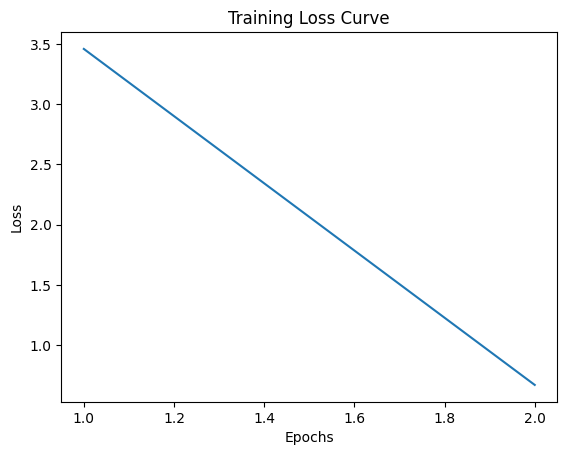

Accuracy on the 10,000 test images: 88.36%


In [43]:
param_vec2, params_shapes = train(num_epochs=2, seed=2)

Set seed=42


  0%|          | 0/5 [00:00<?, ?it/s]

Training completed.


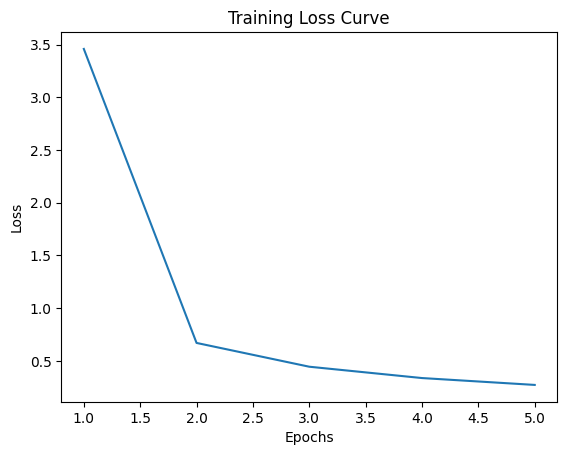

Accuracy on the 10,000 test images: 94.05%


In [44]:
param_vec3, params_shapes = train(num_epochs=5, seed=3)

In [45]:
def evaluate_loss(param_vec, verbose=False):
    loss = 0.
    n_images = 0
    correct = 0
    with torch.inference_mode():

        raw_net = param_vec2net(param_vec, params_shapes)

        for i, data in zip(range(1), testloader):
            images, labels = data

            images, labels = images.to(device), labels.to(device)
            outputs = raw_net.raw_forward(images)

            batch_loss = criterion(outputs, labels)
            loss += batch_loss

            _, predicted = torch.max(outputs.data, 1)
            # print('predicted',predicted)
            n_images += labels.size(0)
            correct += (predicted == labels).sum().item()

    if verbose:
        print(f"Loss={loss} | Accuracy on the {n_images} test images: {100 * correct / n_images}%")
    return loss

# Vizualize simple loss surface

In [46]:
def cos(a, b): return a.dot(b)/(a.norm() * b.norm() + 1e-6)

## Orthogonolization process 

I need to:

1. loss(w1 + u) == loss(w2)
1. loss(w1 + xu + yv) == loss(w3)

where $x,y$ - coordinates of w3 in new frame. How do I find them?

First, I need to answer you how do I find $v$.

In [47]:
u, v = param_vec2, param_vec3
w1 = torch.zeros_like(u)

u = u - w1
v = v - w1

y = cos(u,v)
v = v - y * u

# v = F.normalize(v, dim=0)
normal_u, normal_v = F.normalize(u, dim=0), F.normalize(v, dim=0)
norm_of_u, norm_of_v = u.norm(), v.norm()

In [48]:
evaluate_loss(w1), evaluate_loss(param_vec2).item(), evaluate_loss(param_vec3).item()

(tensor cuda:0 2.303, 0.21936550736427307, 0.10032542794942856)

In [49]:
assert torch.allclose ( evaluate_loss(w1 + u), evaluate_loss(param_vec2) )

In [50]:
assert torch.allclose(evaluate_loss(w1 + y*u + v), evaluate_loss(param_vec3))

In [51]:
max_range = max(norm_of_u, norm_of_v).item() * 2.
max_range

34.59237289428711

In [54]:
x2,y2 = norm_of_u, 0
x3,y3 = norm_of_u*y, norm_of_v

assert torch.allclose ( evaluate_loss(w1 + x2*normal_u + y2*normal_v), evaluate_loss(param_vec2) )

assert torch.allclose ( evaluate_loss(w1 + x3*normal_u + y3*normal_v), evaluate_loss(param_vec3) )

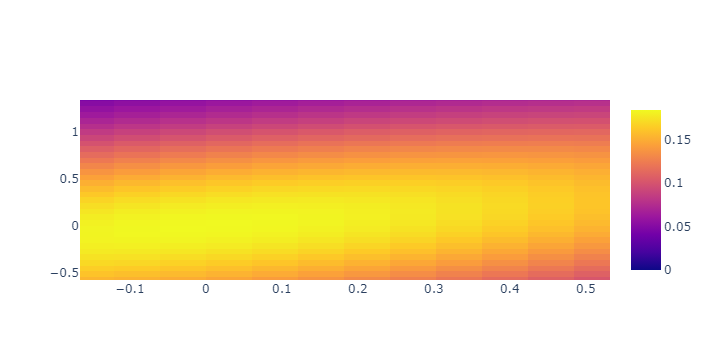

In [64]:
import numpy as np
import plotly.graph_objects as go

# Define the parameters of the 2D Gaussian distribution
mu = np.array([0, 0])
sigma = np.array([[1, 0.5], [0.5, 1]])

# Generate a grid of points in the parameter space
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

# Evaluate the density function at each point in the grid
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = np.exp(-0.5 * np.sum((pos - mu) @ np.linalg.inv(sigma) * (pos - mu), axis=2)) / (2 * np.pi * np.sqrt(np.linalg.det(sigma)))

# Create a heatmap of the density function
fig = go.Figure(data=go.Heatmap(x=x, y=y, z=Z))
fig.show()


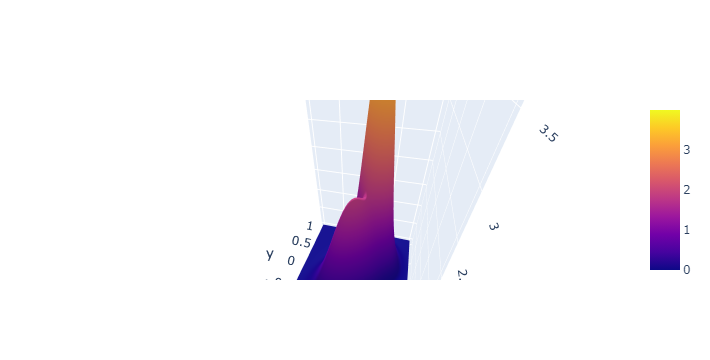

In [70]:
import numpy as np
import plotly.graph_objects as go

# Define the parameters of the two 2D Gaussian distributions
mu1 = np.array([0, 0])
sigma1 = np.array([[1, 0.5], [0.5, 1]])*0.1

mu2 = np.array([.2, 0.6])
sigma2 = np.array([[1, -0.5], [-0.5, 1]])*0.05

# Generate a grid of points in the parameter space
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

# Evaluate the density function of the two 2D Gaussian distributions at each point in the grid
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z1 = np.exp(-0.5 * np.sum((pos - mu1) @ np.linalg.inv(sigma1) * (pos - mu1), axis=2)) / (2 * np.pi * np.sqrt(np.linalg.det(sigma1)))
Z2 = np.exp(-0.5 * np.sum((pos - mu2) @ np.linalg.inv(sigma2) * (pos - mu2), axis=2)) / (2 * np.pi * np.sqrt(np.linalg.det(sigma2)))

# Create a surface plot of the combined density function
fig = go.Figure(data=[go.Surface(x=x, y=y, z=Z1 + Z2)])
fig.show()


In [84]:
x1 = 0.1

xs = torch.linspace(-1, 1, 5)
xs = xs - 0.2*torch.randn_like(xs)
xs.v

tensor[5] x∈[-0.927, 0.971] μ=-0.005 σ=0.775 [-0.927, -0.482, -0.168, 0.583, 0.971]
tensor([-0.9272, -0.4817, -0.1676,  0.5827,  0.9712])

In [89]:
fr = 3e-4

In [106]:
to_right = (xs[1:-1] - xs[:-2]).square()
to_right

tensor[3] x∈[0.099, 0.563] μ=0.287 σ=0.244 [0.198, 0.099, 0.563]

In [107]:
to_left = -(xs[1:-1] - xs[2:]).square()
to_left

tensor[3] x∈[-0.563, -0.099] μ=-0.271 σ=0.254 [-0.099, -0.563, -0.151]

In [108]:
force = to_left + to_right
force

tensor[3] x∈[-0.464, 0.412] μ=0.016 σ=0.444 [0.100, -0.464, 0.412]

In [109]:
xs[1:-1] += fr * force

In [467]:
xs = torch.linspace(-1, 1, 10)
ys = xs.clone()
xs, ys = torch.meshgrid(xs, ys, indexing='ij')
grid = torch.stack([xs, ys])
old_grid = grid.clone()
shape = grid.shape
# grid.v

attractors = [(0,0.), (0.5, 0.5)]
attractors = torch.tensor(attractors).reshape(2,-1)
attractors



for i in range(600):
    for a in attractors:
        diff = -(grid.reshape(2, -1) - a.reshape(2, 1) + .7)
        direction = F.normalize(diff, dim=0)

        square_distance = diff.norm(dim=0)[None]
        square_distance = (1./square_distance)
        square_distance = square_distance.clip(0, 50)
        
        # print('square_distance.max()', square_distance.max())

        force = square_distance * direction
        force = force.reshape(*shape)

        grid += 3e-4*force


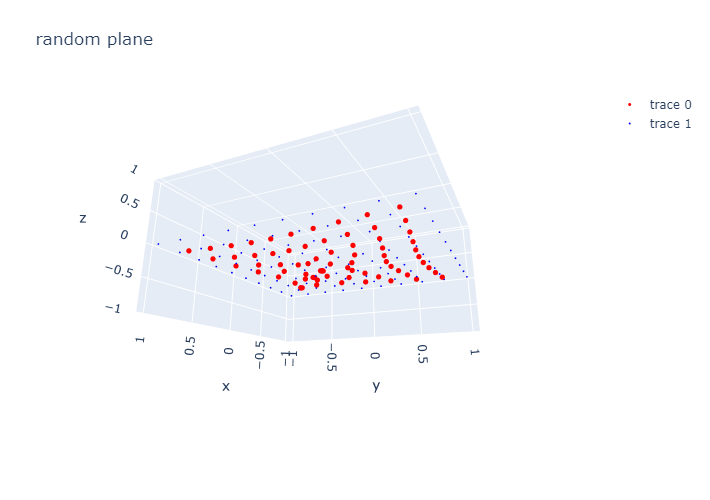

In [468]:
xs, ys = grid.reshape(2, -1).chunk(2)
scatter = go.Scatter3d(x=xs.flatten(), y=ys.flatten(), z=torch.zeros_like(ys).flatten(),
                                   mode='markers+text', marker={"size": 3., 'color': 'red'})



xs, ys = old_grid.reshape(2, -1).chunk(2)
scatter2 = go.Scatter3d(x=xs.flatten(), y=ys.flatten(), z=torch.zeros_like(ys).flatten(),
                                   mode='markers+text', marker={"size": 1., 'color': 'blue'})

fig = go.Figure(data=[scatter, scatter2])
# fig.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                   highlightcolor="limegreen", project_z=True))
fig.update_layout(title='random plane', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

In [444]:
for i in range(100):
    to_right = (xs[1:-1] - xs[:-2]).square()
    to_left = -(xs[1:-1] - xs[2:]).square()
    force = to_left + to_right
    xs[1:-1] -= 1e-4 * force
    
    for a in attractors:
        d = (xs - a)
        attractive_force = d.sign() * (1/( d.square() + 1e-6 ))
        # print(attractive_force)
        xs -= 1e-6*attractive_force
    print(xs.numpy()[:5])

RuntimeError: The size of tensor a (100) must match the size of tensor b (2) at non-singleton dimension 1

tensor[10] x∈[-0.999, 0.999] μ=-1.192e-08 σ=0.704 [-0.999, -0.777, -0.554, -0.328, -0.465, 0.465, 0.328, 0.554, 0.777, 0.999]

In [ ]:
(xs[1:] - xs[:-1]).square()

tensor[4] x∈[-0.927, 0.583] μ=-0.248 σ=0.636 [-0.927, -0.482, -0.168, 0.583]

tensor[4] x∈[0.099, 0.563] μ=0.253 σ=0.211 [0.198, 0.099, 0.563, 0.151]

In [56]:
n = 20
losses = torch.empty(n,n)

arange = torch.linspace(-max_range, max_range, n).numpy()
for i_int, i in enumerate(tqdm(arange)):
    for j_int, j in enumerate(arange):
        w = w1 + i*normal_u + j*normal_v
        loss = evaluate_loss(w)
        losses[i_int,j_int] = loss.item()

  0%|          | 0/20 [00:00<?, ?it/s]

In [60]:
xs = torch.empty(n,n)
ys = torch.empty(n,n)

In [62]:
arange = torch.linspace(-max_range, max_range, n)
for i_int, i in enumerate(tqdm(arange)):
    for j_int, j in enumerate(arange):
        xs[i_int,j_int] = i
        ys[i_int,j_int] = j        

  0%|          | 0/20 [00:00<?, ?it/s]

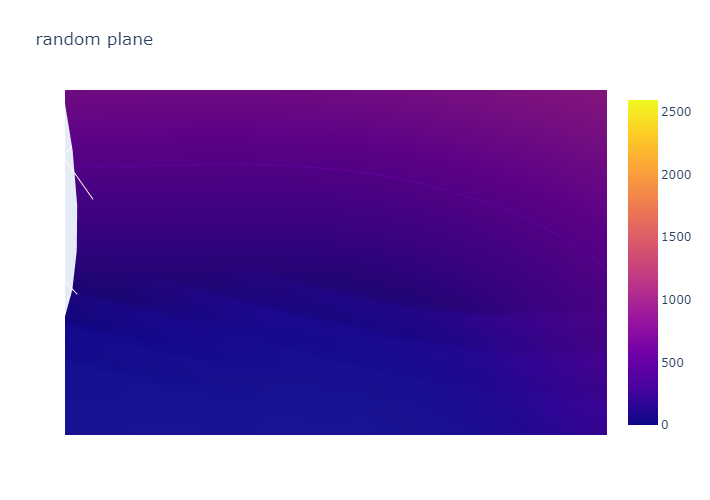

In [63]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(x=xs, y=ys, z=losses)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='random plane', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

# Mode connectivity

$\phi$

In [469]:
class BezierConnectome:
    def __init__(self, w1, w2):
        self.theta = torch.randn_like(w1) * w1.std()

        self.w1 = w1
        self.w2 = w2
        
    def phi(self, t):
        return (1-t**2)*self.w1 + 2*t*(1.-t)*self.theta + t**2*self.w2

In [470]:
w2, w3 = param_vec2, param_vec3

In [471]:
connectome = BezierConnectome(w2, w3)

In [472]:
connectome.theta = connectome.theta.detach()
connectome.theta.requires_grad=True
optimizer = optim.AdamW([connectome.theta], lr=3e-4)

In [473]:
connectome.theta

tensor[4594] x∈[-0.875, 0.878] μ=0.001 σ=0.251 grad cuda:0

In [474]:
def loss_for_w(w):
    loss = 0.
    n_images = 0
    correct = 0

    raw_net = param_vec2net(w, params_shapes)

    for i, data in zip(range(1), testloader):
        images, labels = data

        images, labels = images.to(device), labels.to(device)
        outputs = raw_net.raw_forward(images)

        batch_loss = criterion(outputs, labels)
        loss += batch_loss

        _, predicted = torch.max(outputs.data, 1)
        # print('predicted',predicted)
        n_images += labels.size(0)
        correct += (predicted == labels).sum().item()
    return loss

In [475]:
cbs = 12

In [476]:
for _ in range(100):
    ts = torch.rand(cbs, 1, device=device)
    ws = connectome.phi(ts)
    loss = 0
    for w in ws:
        loss = loss + loss_for_w(w)
    
    loss = loss / cbs
    print(f'{loss:.5f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

16.02907
13.39539
12.35282
14.19304
11.45968
12.45533
13.61286
16.58305
11.89743
12.13244
11.61677
10.76884
8.64893
7.94053
5.45358
6.32237
10.13618
6.87970
8.84999
6.71759
5.53829
4.92985
6.02450
7.00679
5.94746
5.42199
5.18974
6.17319
2.65406
5.90222
6.76738
5.96807
4.71104
4.73412
4.47450
3.78833
4.41967
5.73926
4.68463
3.47366
2.97067
4.21713
4.36136
4.46628
2.36598
2.38468
4.37115
4.78384
2.56350
4.21585
3.14375
3.74788
2.62163
3.10045
2.78263


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49645928c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


3.08444
2.68999


Exception ignored in: <function _releaseLock at 0x7f4a464b93b0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


3.75748


KeyboardInterrupt: 

In [477]:
u, v = param_vec2, param_vec3
w1 = connectome.theta

u = u - w1
v = v - w1

y = cos(u,v)
v = v - y * u

# v = F.normalize(v, dim=0)
normal_u, normal_v = F.normalize(u, dim=0), F.normalize(v, dim=0)
norm_of_u, norm_of_v = u.norm(), v.norm()

In [479]:
n = 10

In [482]:
max_range = max(norm_of_u, norm_of_v).item() * 2.
max_range

48.89924621582031

In [483]:
x2,y2 = norm_of_u, 0
x3,y3 = norm_of_u*y, norm_of_v

assert torch.allclose ( evaluate_loss(w1 + x2*normal_u + y2*normal_v), evaluate_loss(param_vec2) )
assert torch.allclose ( evaluate_loss(w1 + x3*normal_u + y3*normal_v), evaluate_loss(param_vec3) )

In [487]:
x3, y3

(tensor grad MulBackward0 cuda:0 24.428,
 tensor grad NormBackward1 cuda:0 1.036)

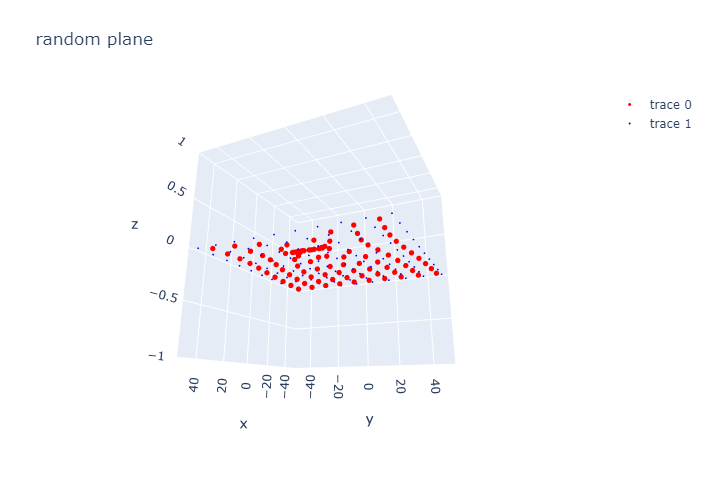

In [488]:
xs = torch.linspace(-max_range, max_range, n)
ys = xs.clone()
xs, ys = torch.meshgrid(xs, ys, indexing='ij')
grid = torch.stack([xs, ys])
old_grid = grid.clone()
shape = grid.shape
# grid.v

attractors = [(x2,y2), (x3, y3)]
attractors = torch.tensor(attractors).reshape(2,-1)
attractors



for i in range(600):
    for a in attractors:
        diff = -(grid.reshape(2, -1) - a.reshape(2, 1) + .7)
        direction = F.normalize(diff, dim=0)

        square_distance = diff.norm(dim=0)[None]
        square_distance = (1./square_distance)
        square_distance = square_distance.clip(0, 50)
        
        # print('square_distance.max()', square_distance.max())

        force = square_distance * direction
        force = force.reshape(*shape)

        grid += 3e-1*force


xs, ys = grid.reshape(2, -1).chunk(2)
scatter = go.Scatter3d(x=xs.flatten(), y=ys.flatten(), z=torch.zeros_like(ys).flatten(),
                                   mode='markers+text', marker={"size": 3., 'color': 'red'})



xs, ys = old_grid.reshape(2, -1).chunk(2)
scatter2 = go.Scatter3d(x=xs.flatten(), y=ys.flatten(), z=torch.zeros_like(ys).flatten(),
                                   mode='markers+text', marker={"size": 1., 'color': 'blue'})

fig = go.Figure(data=[scatter, scatter2])
# fig.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                   highlightcolor="limegreen", project_z=True))
fig.update_layout(title='random plane', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

tensor[2] μ=-40.153 σ=8.237 [-34.329, -45.978]

In [495]:
losses = torch.empty(n,n)

for i_int in tqdm(range(n)):
    for j_int in range(n):
        i,j = grid[:, i_int, j_int]
        w = w1 + i*normal_u + j*normal_v
        loss = evaluate_loss(w)
        losses[i_int,j_int] = loss.item()

  0%|          | 0/10 [00:00<?, ?it/s]

In [497]:
losses

tensor[10, 10] n=100 x∈[0.076, 7.381e+03] μ=1.134e+03 σ=1.440e+03

In [498]:
xs

tensor[1, 100] x∈[-48.899, 48.899] μ=9.155e-07 σ=31.369

In [501]:
grid[0]

tensor[10, 10] n=100 x∈[-45.413, 45.720] μ=2.398 σ=27.278

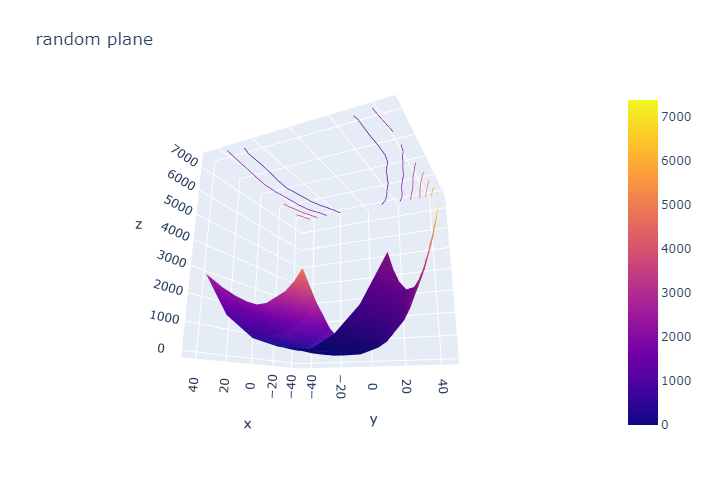

In [502]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(x=grid[0], y=grid[1], z=losses)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='random plane', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()